In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy.signal import convolve2d

# plot helpers
def setplot(p):
    p.axes.xaxis.set_ticks([])
    p.axes.yaxis.set_ticks([])

transparent = clr.colorConverter.to_rgba('white',alpha=0)
grow = clr.ListedColormap([transparent,'green'])
dense = clr.ListedColormap([transparent,'firebrick'])
diffuse = clr.ListedColormap([transparent,'lightcoral'])
persist = clr.ListedColormap([transparent,'grey'])

        
def plotforward(num_board, showfast=False):
    
    # count neighbors
    # https://nicholasrui.com/2017/12/18/convolutions-and-the-game-of-life/
    neigh = np.ones((3,3))
    neigh[1][1] = 0
    neighbors = convolve2d(num_board, neigh, mode='same', boundary='wrap')
    board = (num_board == 1)
    
    # apply rules
    underpop = (neighbors < 2) & board
    survive = np.vectorize(lambda x: 2 <= x <= 3)(neighbors) & board
    overpop = (neighbors > 3) & board
    newgrow = (neighbors == 3) & ~board
    nextboard = newgrow | survive

    # plot it
    fig, plot = plt.subplots(1, 3, figsize=(10,15))
    for p in plot:
        setplot(p)
    plot[0].imshow(board, cmap='binary')
    plot[1].imshow(underpop, cmap=diffuse)
    plot[1].imshow(newgrow, cmap=grow)
    plot[1].imshow(survive, cmap=persist)
    plot[1].imshow(overpop, cmap=dense)
    plot[2].imshow(nextboard, cmap='binary')
    
    if showfast:

        # same thing, but fewer intermediary steps
        cell_ct = np.ones((3,3))
        cells = convolve2d(num_board, cell_ct, mode='same', boundary='wrap')
        fastnext = (cells == 3) | (board & (cells == 4))
        
        # plot it
        fig, plot = plt.subplots(1, 1, figsize=(3,3))
        setplot([plot])
        plot.imshow(fastnext, cmap='binary')
    
    return np.vectorize(lambda x: {True : 1, False: 0}[x])(nextboard)

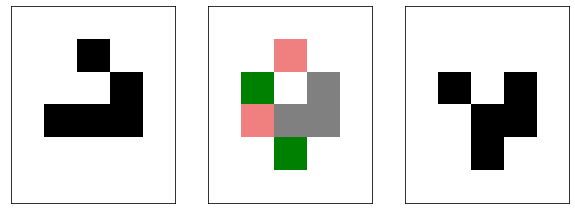

In [264]:
start = np.zeros((6,5))
start[1][2] = 1
start[2][3] = 1
start[3][1] = 1
start[3][2] = 1
start[3][3] = 1

middle = plotforward(start)

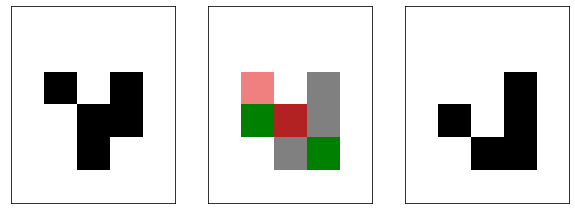

In [265]:
end = plotforward(middle)

In [356]:
from sortedcontainers import SortedDict
from matplotlib.colors import ListedColormap
from IPython.display import display, Math, Latex

bluish = clr.colorConverter.to_rgba('cornflowerblue',alpha=0.4)
purplish = clr.colorConverter.to_rgba('darkorchid',alpha=0.6)

inscope = clr.ListedColormap([transparent,bluish])
targeted = clr.ListedColormap([transparent,purplish])
booltrans =  grow = clr.ListedColormap([transparent,'black'])
gray = clr.ListedColormap(['white','gray'])
lightgray = clr.ListedColormap(['white','lightgray'])

def summarize(story_arc, board, overlap=False):
    
    max_x = board.shape[1]
    max_y = board.shape[0]
    
    if overlap:
        
        # just one plot
        fig, plot = plt.subplots(1, 1, figsize=(2, 2))
        setplot(plot)
        plot.imshow(board, cmap=gray)
        for x, y in story_arc:
            scope = np.zeros((max_y, max_x))
            for oy in range(-1,2):
                for ox in range(-1,2):
                    ix = (x + ox) % max_x 
                    iy = (y + oy) % max_y 
                    scope[iy, ix] = 1
            plot.imshow(scope, cmap=inscope)
            
        return 
                                      
        
    

    y_vals = set(c[1] for c in story_arc)
    min_y = min(y_vals)
    ct_y = len(y_vals)
    ct_x = len(board[0])
    
    include = np.zeros((ct_y, ct_x))
    for x, y in story_arc:
        include[y - min_y][x] = 1

    # layout
    plots_by_y = SortedDict()
    fig, all_plots = plt.subplots(ct_y, ct_x, figsize=(2*ct_x,2*ct_y))
    for (y,x), show in np.ndenumerate(include):
        plot = all_plots[y][x]
        setplot(plot)
        if show:   
            plots_by_y.setdefault(y + min_y, SortedDict())[x] = plot
        else:
            plot.axis('off')
            
    # plots
    for y, plots_by_x in plots_by_y.items():
        for x, plot in plots_by_x.items():
            plot.title.set_text(f"{x},{y}")
            scope = np.zeros((max_y, max_x))
            bullseye = np.zeros((max_y, max_x))
            
            for oy in range(-1,2):
                for ox in range(-1,2):
                    ix = (x + ox) % max_x 
                    iy = (y + oy) % max_y 
                    if oy == ox == 0:
                        bullseye[iy, ix] = 1
                    else:
                        scope[iy, ix] = 1
            plot.imshow(board, cmap=gray)
            plot.imshow(scope, cmap=inscope)
            plot.imshow(bullseye, cmap=targeted)
    
def get_neighborhood(x, y, board):
    max_x = board.shape[1]
    max_y = board.shape[0]
    neighborhood = np.zeros((3,3))
    for oy in range(-1,2):
        for ox in range(-1,2):
            ix = (x + ox) % max_x 
            iy = (y + oy) % max_y
            neighborhood[oy + 1,ox + 1] = board[iy,ix]
    return neighborhood
            
            
def tell(story, board):
    x, y = story
    neighborhood = get_neighborhood(x,y,board)
    fig, plot = plt.subplots(1, 1, figsize=(2,2))
    setplot(plot)
    plot.imshow(neighborhood, cmap=gray)
    targetmask = np.zeros((3,3))
    targetmask[1,1] = 1
    plot.imshow((neighborhood != 0) & (targetmask != 0), cmap=booltrans)
    labels = list("abcdefghi")
    c = 0
    mode = None
    for i in range(3):
        for j in range(3):
            if neighborhood[i,j]:
                mode = 'alive'
                plot.annotate(labels[c],(j,i), color='w', size=14, weight="bold", ha="center", va="center")
            else:
                mode = 'dead'
                plot.annotate(labels[c],(j,i), size=14, weight="bold", ha="center", va="center")
            c += 1
    
    if mode == 'alive':
        display("foo")
    elif mode == 'dead': 
        display("bar")
    else:
        raise Exception(f"what's {mode}")



    
plan = []        # the whole story
summary = []     # the current arc
def storyboard(board, zoom=[]):
    
    def finalize():
        "last cell in a summary, add this summary and start fresh"
        global summary
        if summary:
            plan.append(summary)
            summary = []
                
    # decide which cells to summarize and which to show details for
    for y, rows in enumerate(board):
        for x, cell in enumerate(rows):
            if (x, y) not in zoom:
                summary.append((x, y))
            else:
                summary.append((x, y))
                finalize()
                plan.append((x,y))
    finalize()
    return plan

To run Life backwards we ask:
> Given that this cell is alive/dead at $t$, what could it and its neighbors have been at $t-1$?

If it is **alive**, then maybe it was previously alive with...
 - 2, o living neigbors, or
 - 3  neighbors.
 
Or it could have been dead with...
 - three alive neighbors.

If it is **dead**, then it could have been dead with...
 - 0, 1, 2, or 4 living neighbors
 
Or alive with...
 - 0, 1, or 4 living neighbors

In our 5x6 grid there are 30 cells to ask this about.
Suppose we scan from the top left to the bottom right.

In [357]:
scenes = storyboard(end, zoom=[(3,1),(1,3)])
arc1 = scenes[0]
example1 = scenes[1]
arc2 = scenes[2]
example1 = scenes[3]
arc3 = scenes[4]

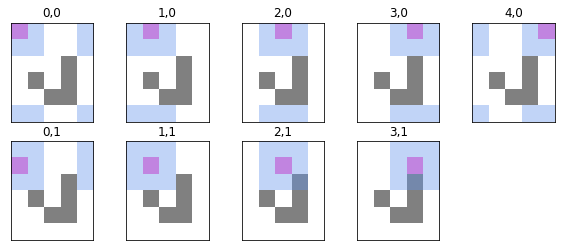

In [358]:
summarize(arc1, end)

Notice that there is a lot of overlap here.
Most of the cells in neighborhood 0,1 are also part of neighborhood 1,1.

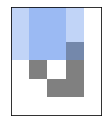

In [355]:
summarize(arc1[6:8], end, overlap=True)